<a href="https://colab.research.google.com/github/nancymahmoud1/Elevvo/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

DATA_DIR = os.path.join(path, "Train")
NUM_CLASSES = 43
IMG_SIZE = 96     #96 instead of 32

def load_data():
    data = []
    labels = []

    for class_id in range(NUM_CLASSES):
        class_path = os.path.join(DATA_DIR, str(class_id))
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(class_id)
            except Exception as e:
                pass

    return np.array(data), np.array(labels)

print("Loading data...")
X, y = load_data()
print("Data loaded:", X.shape, y.shape)


Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Loading data...
Data loaded: (39209, 96, 96, 3) (39209,)


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

y_cat = to_categorical(y, NUM_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


def preprocess_tf(img, label):
    img = tf.image.convert_image_dtype(img, tf.float32)  # convert to float32
    img = preprocess_input(img)  # apply MobileNetV2 scaling
    return img, label

# Convert NumPy arrays to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_tf).batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_tf).batch(64).prefetch(tf.data.AUTOTUNE)

##**Custom CNN model**

In [ ]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train custom CNN model
history_custom = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.9771 - loss: 0.0927 - val_accuracy: 0.9909 - val_loss: 0.0561
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - accuracy: 0.9838 - loss: 0.0622 - val_accuracy: 0.9898 - val_loss: 0.0643
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - accuracy: 0.9837 - loss: 0.0626 - val_accuracy: 0.9862 - val_loss: 0.0892
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.9808 - loss: 0.0841 - val_accuracy: 0.9903 - val_loss: 0.0504
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.9833 - loss: 0.0654 - val_accuracy: 0.9898 - val_loss: 0.0595
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.9867 - loss: 0.0489 - val_accuracy: 0.9923 - val_loss: 0.0459
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.9873 - loss: 0.0499 - val_accuracy: 0.9881 - val_loss: 0.0770
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.9837 - loss: 0.0698 - val_accu

In [ ]:
model.save("custom_model_traffic_sign_model.h5")


In [ ]:
# Evaluate Custom CNN
loss1, acc1 = model.evaluate(X_test, y_test)
print(f"Custom CNN Accuracy: {acc1:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.9904 - loss: 0.0559
Custom CNN Accuracy: 0.9907


# **Build the Pre-trained Model (MobileNetV2)**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Resize MobileNet input if needed (MobileNetV2 expects at least 32x32)
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    alpha=1.0
)

base_model.trainable = False  # Freeze feature extractor

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train MobileNetV2-based model
history_mobilenet = mobilenet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 240s 239ms/step - accuracy: 0.1989 - loss: 3.0070 - val_accuracy: 0.4277 - val_loss: 1.9193
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 295s 274ms/step - accuracy: 0.3793 - loss: 2.0549 - val_accuracy: 0.4908 - val_loss: 1.6386
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 324s 276ms/step - accuracy: 0.4223 - loss: 1.8608 - val_accuracy: 0.5105 - val_loss: 1.5392
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 317s 271ms/step - accuracy: 0.4522 - loss: 1.7401 - val_accuracy: 0.5581 - val_loss: 1.4229
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 286s 234ms/step - accuracy: 0.4741 - loss: 1.6446 - val_accuracy: 0.5754 - val_loss: 1.3493
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 267s 272ms/step - accuracy: 0.4919 - loss: 1.5892 - val_accuracy: 0.5760 - val_loss: 1.3368
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 267s 272ms/step - accuracy: 0.5000 - loss: 1.5558 - val_accuracy: 0.5862 - val_loss: 1.2984
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 322s 272ms/step - accuracy: 0.5070 -

In [ ]:
# Evaluate MobileNetV2
loss2, acc2 = mobilenet_model.evaluate(X_test, y_test)
print(f"MobileNetV2 Accuracy: {acc2:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 45s 182ms/step - accuracy: 0.6291 - loss: 1.1910
MobileNetV2 Accuracy: 0.6250


In [ ]:
# Save the model
mobilenet_model.save("mobilenetv2_traffic_sign_model.h5")

In [ ]:
# Load Later
from tensorflow.keras.models import load_model

model = load_model("mobilenetv2_traffic_sign_model.h5")

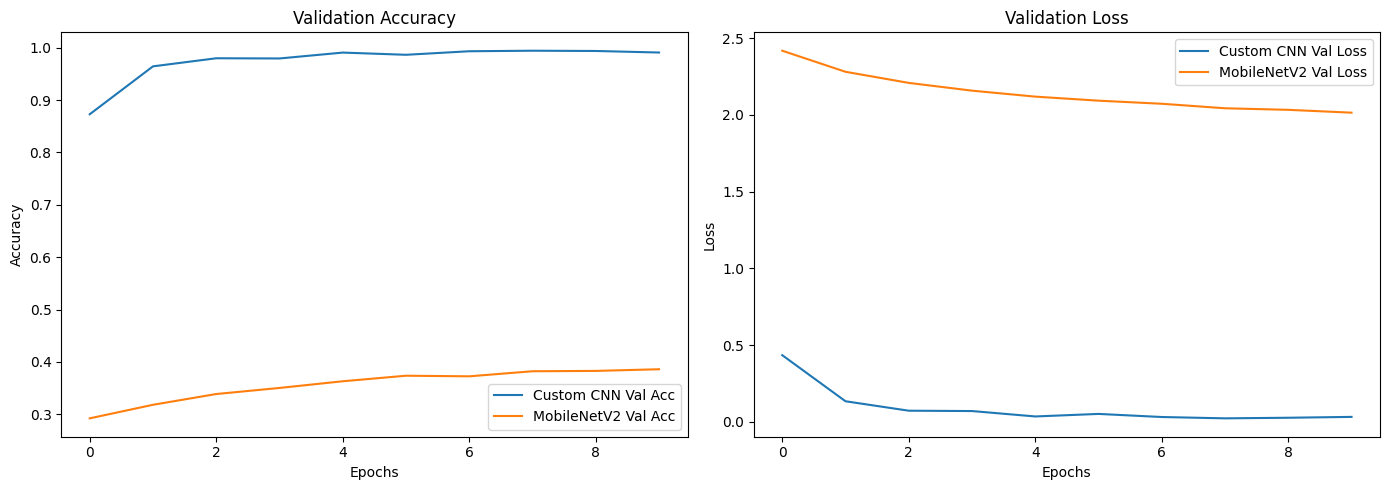

In [ ]:
def plot_history(hist1, hist2, label1='Custom CNN', label2='MobileNetV2'):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist1.history['val_accuracy'], label=f'{label1} Val Acc')
    plt.plot(hist2.history['val_accuracy'], label=f'{label2} Val Acc')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist1.history['val_loss'], label=f'{label1} Val Loss')
    plt.plot(hist2.history['val_loss'], label=f'{label2} Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_custom, history_mobilenet)

# **Confusion Matrix**

In [ ]:
# Predict for Custom CNN
y_pred_custom = model.predict(X_test)
y_pred_classes_custom = y_pred_custom.argmax(axis=1)

# Predict for MobileNet
y_pred_mobilenet = mobilenet_model.predict(X_test)
y_pred_classes_mobilenet = y_pred_mobilenet.argmax(axis=1)

# True labels (same for both)
y_true = y_test.argmax(axis=1)


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
cm_custom = confusion_matrix(y_true, y_pred_classes_custom)
cm_mobilenet = confusion_matrix(y_true, y_pred_classes_mobilenet)

In [ ]:
# print("Classification Report:")
# print(classification_report(y_true, y_pred_classes_custom))

# print(cm_custom)

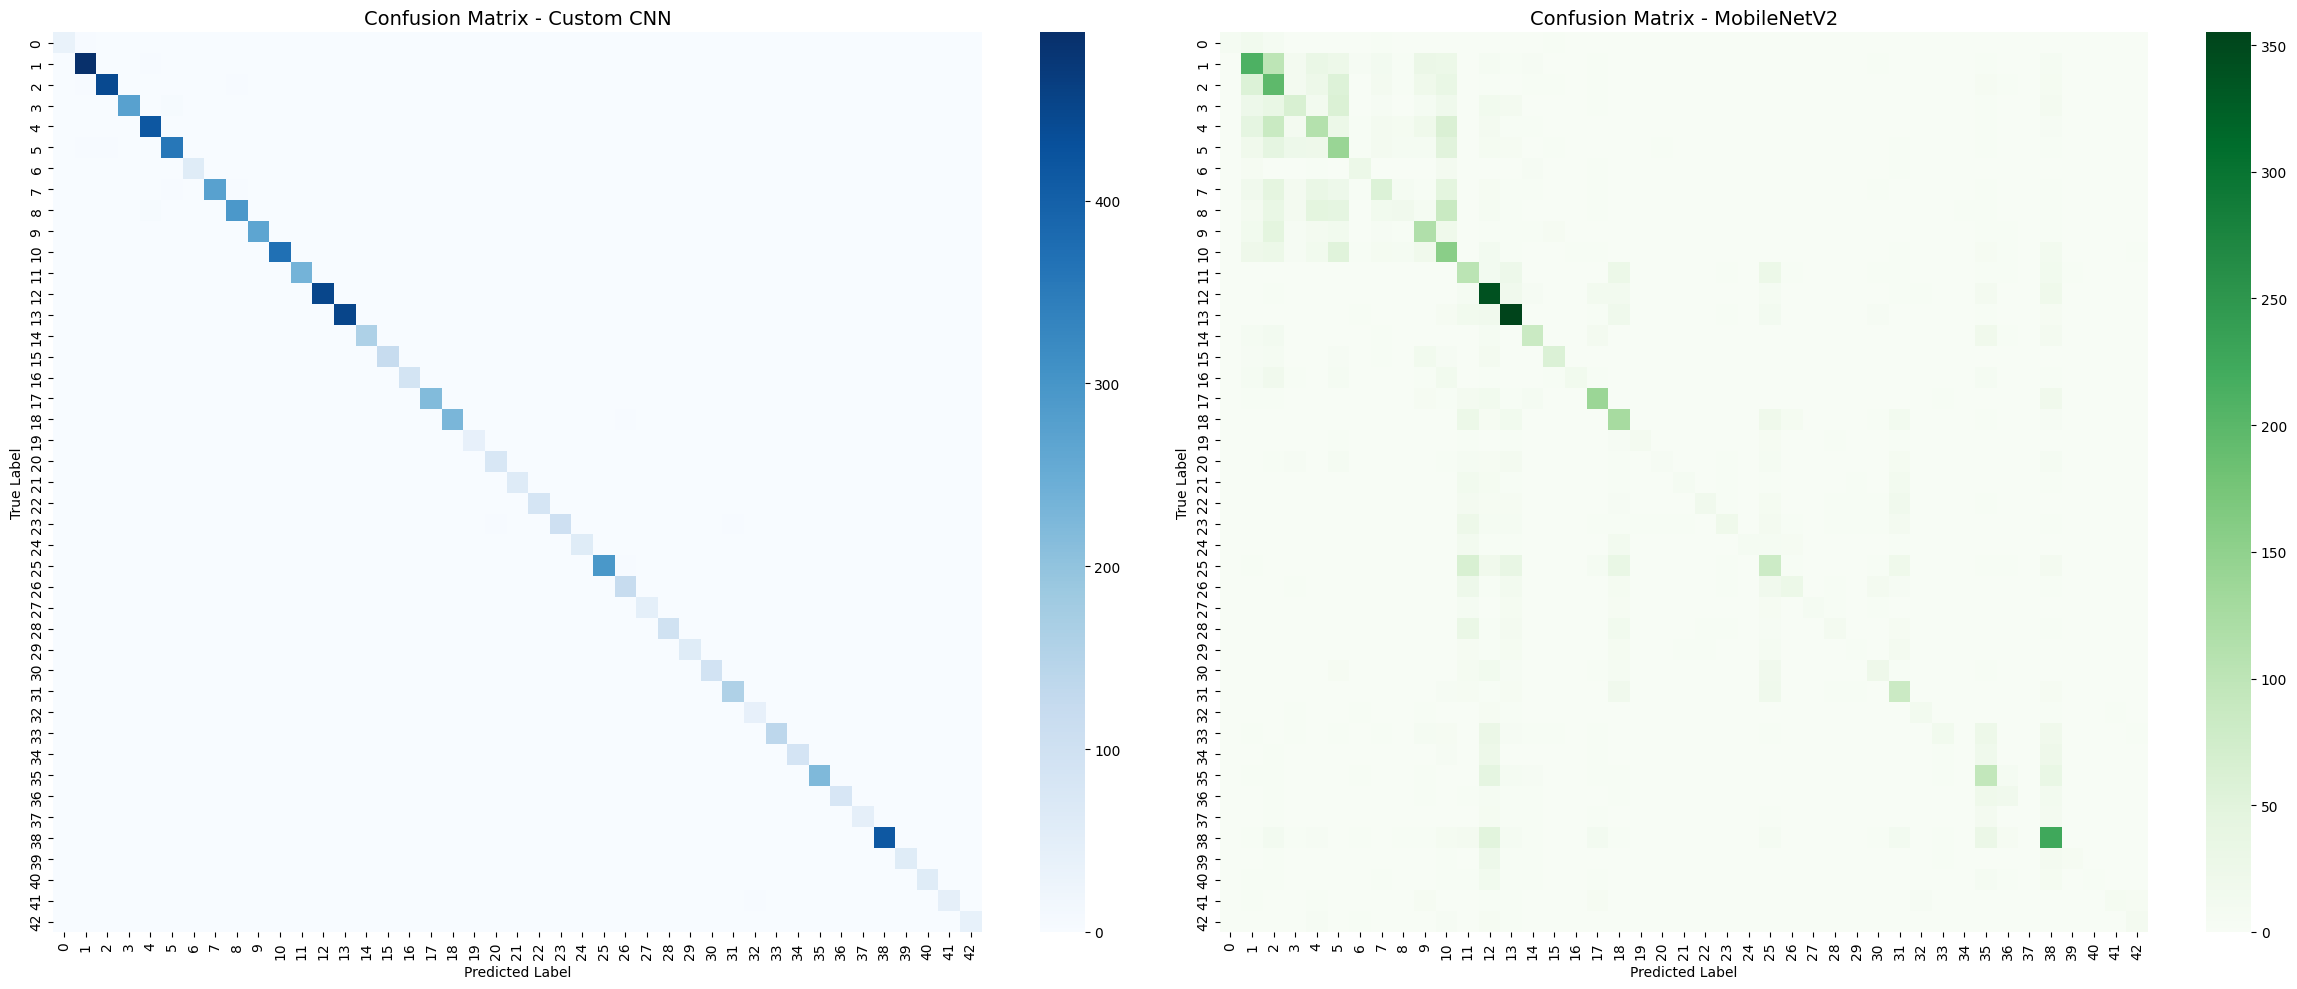

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot Custom CNN
sns.heatmap(cm_custom, ax=axes[0], cmap='Blues', annot=False, cbar=True)
axes[0].set_title("Confusion Matrix - Custom CNN", fontsize=14)
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot MobileNetV2
sns.heatmap(cm_mobilenet, ax=axes[1], cmap='Greens', annot=False, cbar=True)
axes[1].set_title("Confusion Matrix - MobileNetV2", fontsize=14)
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

# **Confusion Matrix For Custom CNN model**

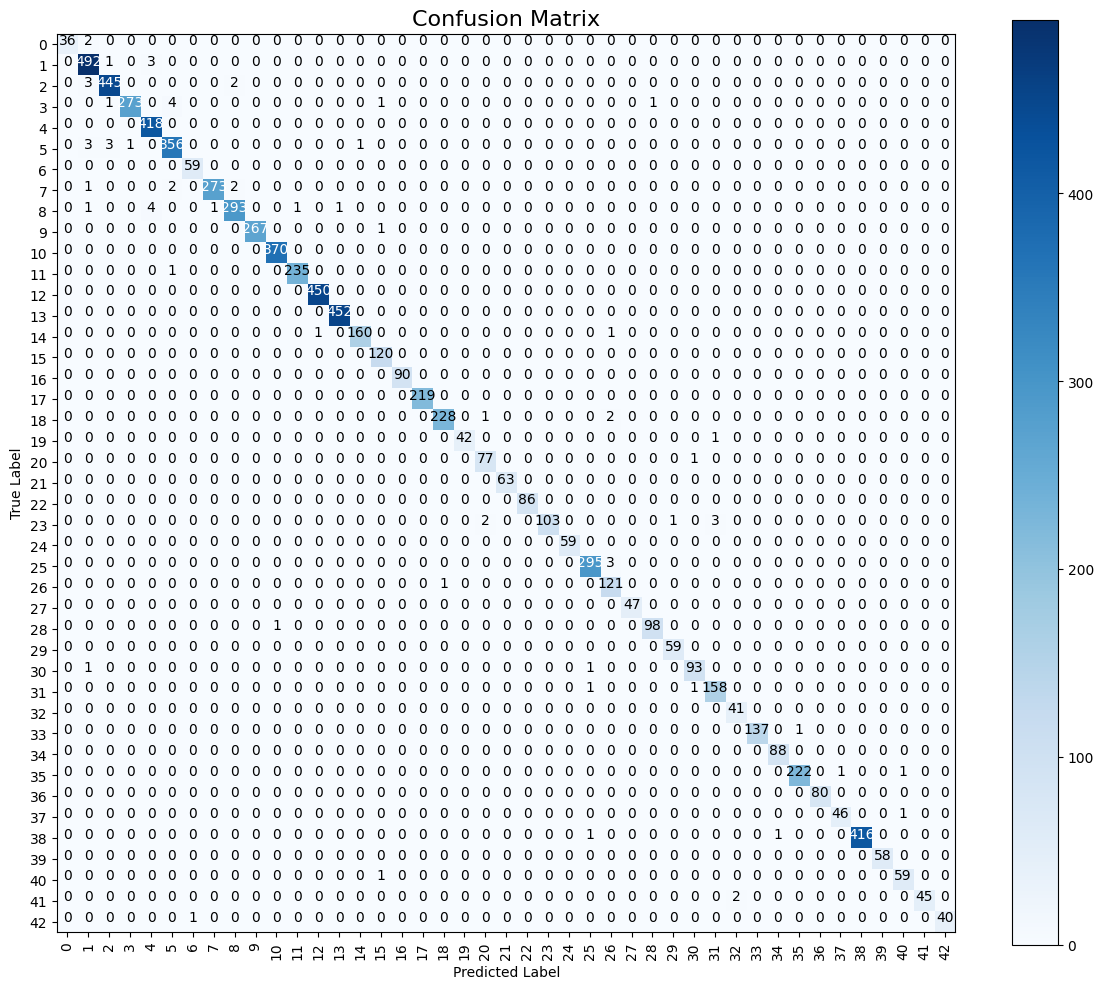

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))

    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    # Add numbers inside the matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Use class names as strings of their index
class_names = [str(i) for i in range(43)]
plot_confusion_matrix(cm, class_names)


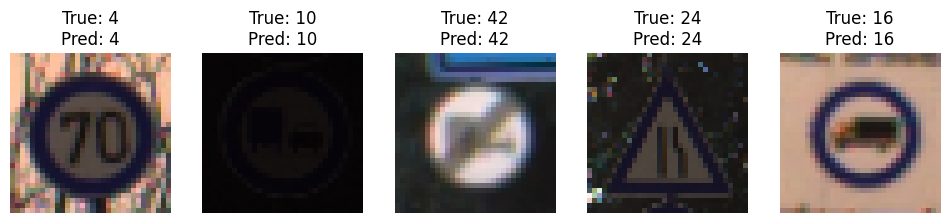

In [ ]:
# Visualize Predictions
def show_samples(X, y_true, y_pred, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true = y_true[idx]
        pred = y_pred[idx]

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"True: {true}\nPred: {pred}")
        plt.axis('off')
    plt.show()

show_samples(X_test, y_true, y_pred_classes_custom)